# Prototypical Networks

This notebook implements the Prototypical Network in TensorFlow. Inspiration has been drawn from the authors implementation in PyTorch, and the constructs for the model definition are mostly similar, since Torch and TF share some similarity in that section. 

Training however, is different as TF does not support the `loss.backward()` style of backprop. So the conventional, gritty gradient tape method has been used. 

Things to note: Do not train with default configs until you are sure you can wait for periods of half-hour or longer. Reduce `epoch_size` if you wish to make things go along faster. 

Alternatively, for testing, you could just load weights that have been saved previously. The last saved checkpoint will be loaded and results will be shown. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2
import time

import tqdm
from tqdm.notebook import trange

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Extraction

This part deals with the extraction of data from the Omniglot dataset of alphabets. 

The Omniglot dataset contains 1,623 different handwritten characters from 50 different alphabets. Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people (so 20 examples per character). It is split into a background set of 30 alphabets and an evaluation set of 20 alphabets. We will use the background set for training and the evaluation set for testing.

The function `read_alphabets()` was taken from Cyprien Nielly's implementation (GitHub) , as the original code I had written took too much time to extract and organise the dataset. Cyprien's function uses the multiprocessing module to accelerate the extration of the data. 


In [2]:
# DO NOT RUN IF DATASET HAS ALREADY BEEN EXTRACTED

!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

replace images_background/Alphabet_of_the_Magi/character01/0709_01.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
replace images_evaluation/Angelic/character01/0965_01.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
def read_alphabets(alphabet_directory_path, alphabet_directory_name):
    """
    Reads all the characters from a given alphabet_directory
    """
    datax = []
    datay = []
    characters = os.listdir(alphabet_directory_path)
    for character in characters:
        images = os.listdir(alphabet_directory_path + character + '/')
        for img in images:
            image = cv2.resize(
                cv2.imread(alphabet_directory_path + character + '/' + img),
                (28,28)
                )
            #rotations of image
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            datax.extend((image, rotated_90, rotated_180, rotated_270))
            datay.extend((
                alphabet_directory_name + '_' + character + '_0',
                alphabet_directory_name + '_' + character + '_90',
                alphabet_directory_name + '_' + character + '_180',
                alphabet_directory_name + '_' + character + '_270'
            ))
    return np.array(datax), np.array(datay)

def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_alphabets,
                          args=(
                              base_directory + '/' + directory + '/', directory, 
                              )) for directory in os.listdir(base_directory)]
    pool.close()
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [3]:
%%time 
trainx, trainy = read_images('images_background')

CPU times: user 409 ms, sys: 518 ms, total: 927 ms
Wall time: 34.7 s


In [4]:
%%time 
testx, testy = read_images('images_evaluation')

CPU times: user 200 ms, sys: 306 ms, total: 506 ms
Wall time: 28.4 s


In [5]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((77120, 28, 28, 3), (77120,), (52720, 28, 28, 3), (52720,))

## Creating samples and training 

This section is to create a random sample of a support set and query set from the data set. Now, the assumption made here is that `n_query` number of query images will be extracted per class. However, a more general structure of the model would be to provide a completely random set of query images. This constraint has been applied to ease out loss calculation, and training. 

In [6]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay==cls] 
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support+n_query)]
        sample.append(sample_cls)                   # images extracted
    
    sample = np.array(sample)   # convert to np format
    sample = tf.image.convert_image_dtype(sample, dtype=tf.float32)
    
    return {'images':sample, 'n_way': n_way, 'n_support': n_support, 'n_query': n_query} 
    

In [7]:
def display_sample(sample):
    
    images = sample['images']
    n_way = sample['n_way']
    im_per_way = images.shape[1]
    
    plt.figure(figsize=(16,7))
    for i in range(n_way*im_per_way):
        row = i//im_per_way
        offset = i-row*im_per_way
        
        plt.subplot(n_way, im_per_way, i+1)
        plt.imshow(images[row, offset])
    

Looking at example of a sample set. 

In [9]:
sample = extract_sample(8,5,5, trainx, trainy)
print("Shape of the extracted sample is : ",sample['images'].shape)

Shape of the extracted sample is :  (8, 10, 28, 28, 3)


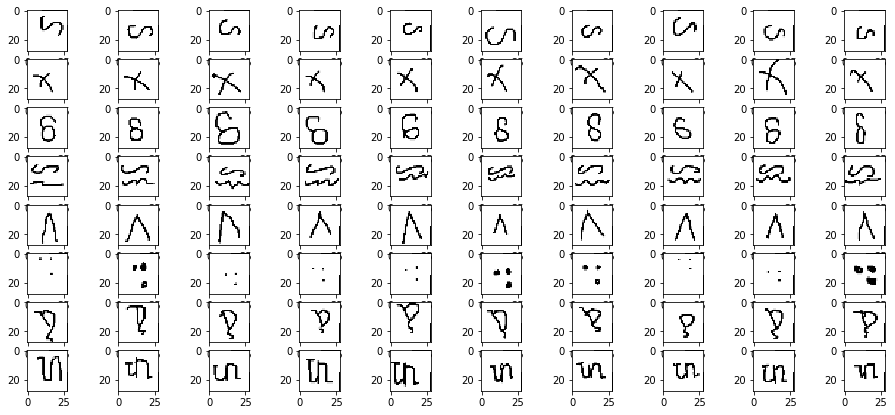

In [10]:
display_sample(sample)

## Building the model

The model is basically a CNN. Instead of using the flattened outputs as a measure of probability, we use the output as a vector that desribes the features of the image. Calculating L2 distance with the prototype of the class, we obtain the distance. 

The log softmax is taken as a loss metric. 

In [11]:
def convolution_block( n_filters):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D( filters = n_filters, kernel_size = 3, padding = 'same'), 
        tf.keras.layers.BatchNormalization(-1), 
        tf.keras.layers.ReLU(), 
        tf.keras.layers.MaxPool2D((2,2))
    ])

In [12]:
class ProtoNet(tf.keras.Model):
    
    def __init__(self, n_filters, output_dim):
        '''
        Args:
        n_filters = number of filters in convolutional layers
        output_dim = dimensions of output 
        
        '''
        super(ProtoNet, self).__init__()
        
        self.encoder = tf.keras.Sequential([
            convolution_block(n_filters), 
            convolution_block(n_filters), 
            convolution_block(n_filters), 
            convolution_block(output_dim), 
            tf.keras.layers.Flatten()
        ])
        
        
    def call(self, sample):
        
        '''
        Args: 
        
        sample: object returned by extract_sample()
                {'images': images, 'n_way':n_way, 'n_support': n_support, 'n_query': n_query }
                
        Returns: 
        
        vector of dimensions output_dim '''
        
        # The input is a 5-dimensional tensor, and the Sequential block demands an input of 4_D dimensionality. 
        # Therefore, we flatten along axis 0, keeping all the images of the same class together. 
        
        images = sample['images']
        self.n_way = sample['n_way']
        self.n_support = sample['n_support']
        self.n_query = sample['n_query']
        
        im_support = images[:,:self.n_support]    # Seperating the support set from query set
        im_query = images[:, self.n_support:]
        
        x = tf.concat([
        tf.reshape(im_support, (self.n_way*self.n_support, *images.shape[2:])), 
        tf.reshape(im_query, (self.n_way*self.n_query, *images.shape[2:]))],
        axis = 0)                            # Data is now in 4-D form
        
        embedding = self.encoder(x)
        return embedding
    
    def euclidian_dist(self, x , y):
    
        ''' This calculates the euclidian distance between two 2-D vectors. 
        The first dimension need not be equal for the vectors, but the second has to be 
    
        Args:
        x: dimension (k, len) vector (considered as query)
        y: dimension (n, len) vector (considered as prototype) 
        Returns: 
        distances: vector of (k,n) dimension, representing distance of each query from each prototype'''
    
        k, x_len = x.shape
        n, y_len = y.shape
    
        assert x_len == y_len, "Length of query and prototype embeddings dont match"
    
        x = tf.tile(tf.expand_dims(x, 1), (1,n,1) )
        y = tf.tile(tf.expand_dims(y, 0), (k,1,1) )
    
        distances = tf.reduce_sum(tf.math.pow(x-y,2), axis=2)
    
        return distances
    
    def forward_loss(self, sample):
        
        out = self(sample)
        
        indices = tf.range(0,n_way,dtype='int64') 
        indices = tf.reshape(indices, (self.n_way,1))
        indices = tf.tile(indices, (1,self.n_query))
        
        embed_size = out.shape[-1]
        
        support = tf.reshape(out[:self.n_way*self.n_support], (self.n_way, self.n_support, embed_size))
        proto = tf.math.reduce_mean(support, 1)
        query = out[self.n_way*self.n_support:]
        
        distances = self.euclidian_dist(query, proto)
        
        #computing log softmax over distances
        
        log_prob = tf.nn.log_softmax(-distances, axis=-1)
        log_prob = tf.reshape(log_prob, (n_way, n_query, -1))
        
        loss = tf.math.reduce_mean(tf.gather(-log_prob, indices, batch_dims=2))
        y_hat = tf.math.argmax(log_prob, axis=2)
        accuracy = tf.math.reduce_mean(tf.cast(tf.math.equal(y_hat, indices), dtype=tf.float32))
        
        return loss, {'loss': loss.numpy(), 
                'accuracy': accuracy.numpy(), 
                'y_hat': y_hat.numpy()}
    
    def save_model(self,path):
        self.save_weights(path)
        
    def load(self,path):
        self.encoder(tf.zeros([1,28,28,3]))
        self.load_weights(path)


## Training the model

Training the model is done with the same procedure we expect to test it with. Conventionally, it would be possible to just call the model.fit along with the dataset, but since out training procedure is unique to theis network, we need to define the training function from scratch. 

An N-way, K-shot network will be fed with K images each of N classes as a support set, accompanied by a certain amount of query images. For ease of training, I have set the query set to include X images each from every class (this is not required). The ProtoNet builds the prototype of the model with its weights and then compares the distance of each query to each class, predicting the class as the one which gives the lowest distance. This constitutes one training episode. 

We keep `epoch_size` number of training episodes per epoch, and as usual, run for necessary number of epochs

Note: With the current configuration, the training takes a total of 40 minutes on my computer (16 GB RAM, 4 GB GPU). Each epoch takes 20 mins to train. It is highly recommended that for faster training times, AWS services are used. At the time of writing this code, I'm looking into free AWS compute services that I can sign up for. 


In [13]:
def train (model, init_lr, train_x, train_y, n_way, n_support, n_query, epochs, epoch_size):
    
    """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      epochs (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
    
    lr  = init_lr
    optimizer = tf.keras.optimizers.Adam(lr)
    epoch = 0
    
    while epoch < epochs  :
        r_loss = 0.0
        r_acc = 0.0
        
        for episode in trange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            
            with tf.GradientTape() as tape:
                loss, out = model.forward_loss(sample)
        
            grads = tape.gradient(loss, model.trainable_variables)
            
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            r_loss += out['loss']
            r_acc += out['accuracy']
            
        epoch_loss = r_loss / epoch_size
        epoch_acc = r_acc / epoch_size
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        epoch += 1
        lr = lr/2
        
       

In [14]:
%%time

model = ProtoNet(64,64)
checkpoint_file = 'ProtoNet'+ time.strftime("%d%m_%I%M")+'.weights'

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 2
epoch_size = 2000

train(model, 0.001, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

model.save(f'model_weights/{checkpoint_file}')


KeyboardInterrupt: 

## Testing the model 

Testing the model is done the same way we trained the model, by feeding it a support set, query set and calculating necessary metrics. 
 
Testing the model has been done by using the last saved checkpoint so as to avoid retraining the model all the time. 

In [15]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on 
      """
    r_loss = 0.0
    r_acc = 0.0
    
    for episode in trange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.forward_loss(sample)
        r_loss += output['loss']
        r_acc += output['accuracy']
    avg_loss = r_loss / test_episode
    avg_acc = r_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))
    
    

In [30]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

my_model = ProtoNet(64,64)
sample = extract_sample(n_way, n_support, n_query, test_x, test_y)

my_model.load(tf.train.latest_checkpoint('model_weights'))

test(my_model, test_x, test_y, n_way, n_support, n_query, test_episode)

display_sample(sample)
out = my_model.forward_loss(sample)
print("The model's prediction is: ",out['y_hat'] )


Test results -- Loss: 0.0132 Acc: 0.9967


As expected, the model is following loss patterns that seem to mimic the ones given in the paper. Since the paper trains for 5 epochs and that would mean a training time of 2 hours, which I am reluctant to undertake on my PC. As soon as I understand how to use AWS compute services, further training of the model can be performed on the cloud. 

## Further steps

Further steps to be taken are the following:

1. Generalising the support set and query set, and modifying the model accordingly. The final objective is to create a ProtoNet that accepts one query image and 3 support images for the face. 

2. The current method of training will require images to be provided of the 'not-authorized' category. This is generally not done in most face detection systems, and therefore, something needs to be thought of. 

3. Training the ProtoNet on the CelebA database. This step will definitely need to be undertaken on AWS VM, since the input features will be significantly larger than the Omniglot dataset

4. Possible accellerations within code will need to be thought of. Since TFLite will probably compile the model class, it might be best to code the class as efficiently as possible. 

In [8]:
x = tf.random.uniform((1,4,3,1))
max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same')

max_pool_2d(x)

<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[0.945794  ],
         [0.5393721 ]],

        [[0.9488752 ],
         [0.38950348]]]], dtype=float32)>